In [128]:
import json
import requests

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from operator import itemgetter
from pathlib import Path

import math
import scipy.stats as st # used for confidence interval
import matplotlib.patches as mpatches # used for rectangles in plots
from sklearn.cluster import KMeans # used for K-Means Clustering

from pprint import pprint

In [28]:
df = pd.read_csv(Path.cwd() / 'suicideVSgdp.csv')

In [29]:
df

,country,year,sex,age,suicides_no,population,suicide_per_hundred_k_pop,country-year,HDI for year,gdp_for_year,gdp_per_capita,generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z


In [46]:
# Data availability in each year differs by country and by year
# GDP per capita is the same across all demographic groups of a country in a given year
years = df.loc[:,'year']
year_extent = (min(years), max(years))
# for i in range(year_extent[0], year_extent[1]+1):
#     print(i)

In [52]:
countries = sorted(list(set(df.loc[:,'country'])))
# countries

In [130]:
albania = {}
df_albania = df.loc[df['country']=='Albania'] # df filtered to country == Albania
albania_years = df_albania.loc[:, 'year'] # pd series of years (overlaps due to different demographic groups)
albania['years'] =  sorted(list(set(albania_years))) # unique list(range) of years

albania_gdp_per_capita = []
albania_suicide_per_hundred_k_pop = []
for year in albania['years']:
    
    try: # ensure all gdp_per_capita in a given year is same across demographic groups
        gdp_pc = list(df_albania.loc[df['year']==year, ['gdp_per_capita']].squeeze())
        
        if not all(list(map((lambda x: x==gdp_pc[0]), gdp_pc))):
            raise Exception(f"invalid gdp_per_capita data")
    except Exception as e:
        print(e)
    else:
        albania_gdp_per_capita.append(gdp_pc[0])
        
    suicide_count = sum(list(df_albania.loc[df['year']==year, ['suicides_no']].squeeze()))
    population = sum(list(df_albania.loc[df['year']==year, ['population']].squeeze()))
    suicide_per_hundred_k_pop = (10**5)*suicide_count/population
    albania_suicide_per_hundred_k_pop.append(suicide_per_hundred_k_pop)
albania['gdp_per_capita'] = albania_gdp_per_capita
albania['suicide_per_hundred_k_pop'] = albania_suicide_per_hundred_k_pop
# albania['suicide_per_hundred_k_pop']
# len(albania['suicide_per_hundred_k_pop']) == len(albania['gdp_per_capita'])
# len(albania['years'])==len(albania['gdp_per_capita'])
# pprint(albania)

In [146]:
def suicide_rate2area(suicide_rates): # function to return a list of area for points at corresponding index
    area_list = []
    for rate in suicide_rates:
        area_list.append(50*rate**2)
        # squared since area is proportional to square of the value
        # factor by half to adjust final area when plotted
    return area_list
# areas = overall_percent_poverty2area(list(map(locality_name2overall_percent_poverty, locality_name_list)))

In [170]:
def suicide_rate2area_ver2(suicide_rates): # function to return a list of area for points at corresponding index
    area_list = []
    for rate in suicide_rates:
        area_list.append(0.0001*rate**2)
        # squared since area is proportional to square of the value
        # factor by half to adjust final area when plotted
    return area_list
# areas = overall_percent_poverty2area(list(map(locality_name2overall_percent_poverty, locality_name_list)))

In [156]:
def suicide_rate2color(suicide_rates):
    color_list = []
    for rate in suicide_rates:
        color_list.append(rate**2)
        # squared since area is proportional to square of the value
        # factor by half to adjust final area when plotted
    return color_list
# areas = overall_percent_poverty2area(list(map(locality_name2overall_percent_poverty, locality_name_list)))

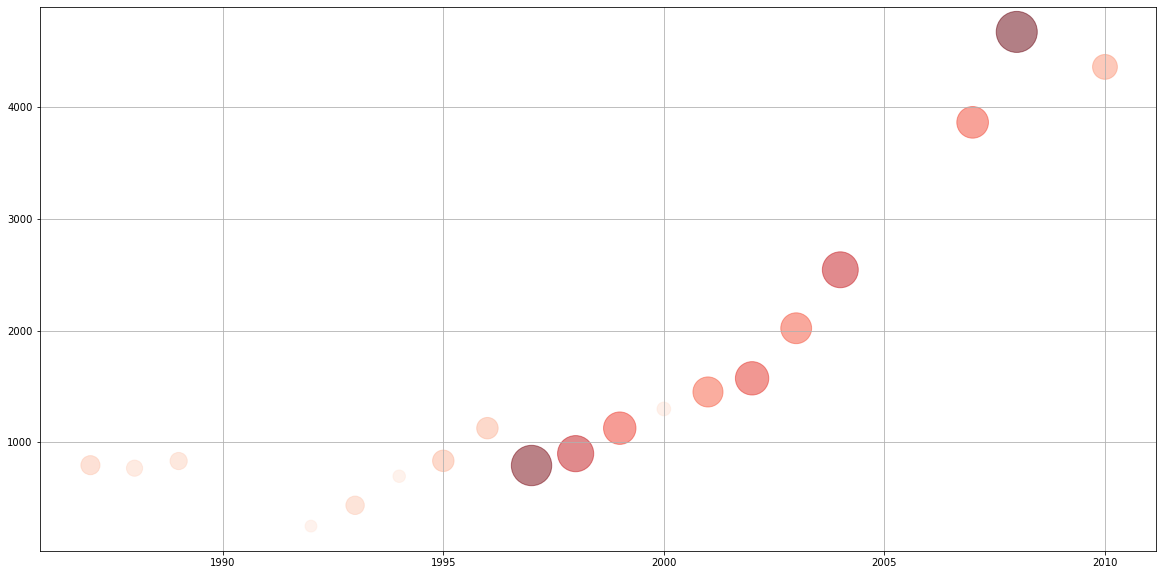

In [158]:
fig, ax = plt.subplots(1,1)
# color_map = plt.cm.get_cmap('Reds')
ax.scatter(albania['years'], albania['gdp_per_capita'], 
           c = suicide_rate2color(albania['suicide_per_hundred_k_pop']), cmap = plt.cm.get_cmap('Reds'), 
           s = suicide_rate2area(albania['suicide_per_hundred_k_pop']), 
           alpha = 0.5)
plt.rcParams["figure.figsize"] = (20, 10)
ax.grid()
plt.show()

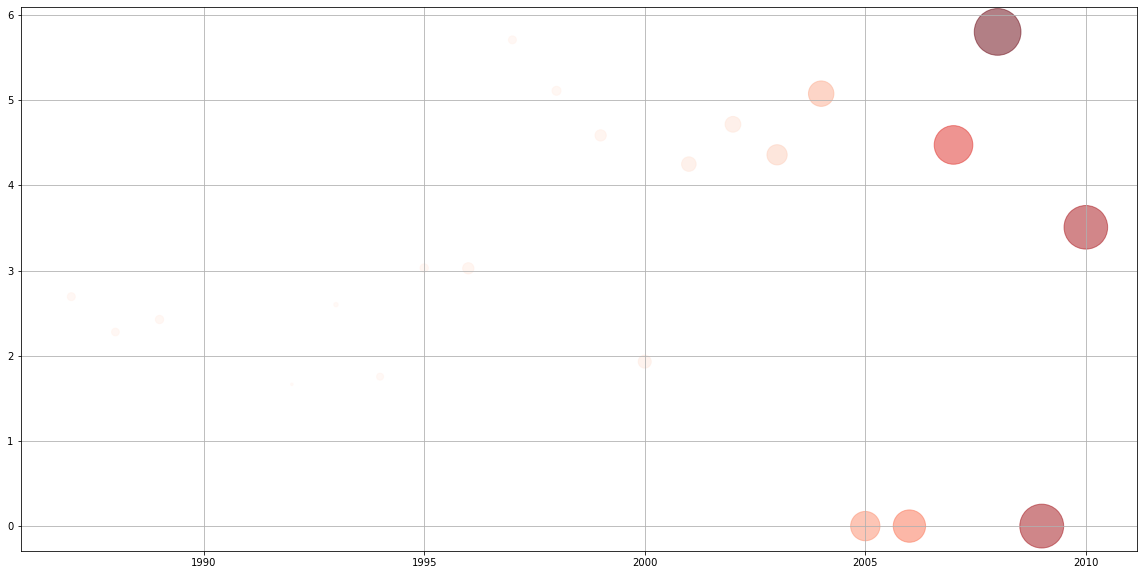

In [171]:
fig, ax = plt.subplots(1,1)
# color_map = plt.cm.get_cmap('Reds')
ax.scatter(albania['years'], albania['suicide_per_hundred_k_pop'], 
           c = suicide_rate2color(albania['gdp_per_capita']), cmap = plt.cm.get_cmap('Reds'), 
           s = suicide_rate2area_ver2(albania['gdp_per_capita']), 
           alpha = 0.5)
plt.rcParams["figure.figsize"] = (20, 10)
ax.grid()
plt.show()

In [172]:
albania

{'years': [1987,
  1988,
  1989,
  1992,
  1993,
  1994,
  1995,
  1996,
  1997,
  1998,
  1999,
  2000,
  2001,
  2002,
  2003,
  2004,
  2005,
  2006,
  2007,
  2008,
  2009,
  2010],
 'gdp_per_capita': [796,
  769,
  833,
  251,
  437,
  697,
  835,
  1127,
  793,
  899,
  1127,
  1299,
  1451,
  1573,
  2021,
  2544,
  2931,
  3235,
  3863,
  4672,
  4387,
  4359],
 'suicide_per_hundred_k_pop': [2.69412459403602,
  2.279057989364396,
  2.4258856266276623,
  1.6651904340124004,
  2.6003633384390694,
  1.7548169725897589,
  3.03092925535579,
  3.027004965648595,
  5.709871359957008,
  5.111693829455306,
  4.587912994685943,
  1.931123270035404,
  4.250988354792489,
  4.718254572183796,
  4.360165109607166,
  5.078276766779444,
  0.0,
  0.0,
  4.47597843444713,
  5.803285312356391,
  0.0,
  3.5087398689704954]}